## Battery info for report

In [88]:
from base.influx_utils import fetch_battery_info
battery_info = fetch_battery_info(
    start_hours=24 * 7 * 50,
    interval_hours=24 * 7 * 50
)

In [89]:
battery_df = pd.DataFrame(battery_info)
battery_df['timestamp'] = pd.to_datetime(battery_df['timestamp'], unit='ms')
battery_df['sensor'] = battery_df['sensor'].apply(lambda x: x[0])
battery_df = battery_df.sort_values(by='timestamp')

In [90]:
battery_df

,sensor,bucket,timestamp,value,field,type
0,kitchen_battery,1_5_10,2024-10-31 12:14:06,51.0,soc,battery
3839,kitchen_battery,1_5_10,2024-10-31 12:14:06,3.8,voltage,battery
3840,kitchen_battery,1_5_10,2024-10-31 12:14:39,3.8,voltage,battery
1,kitchen_battery,1_5_10,2024-10-31 12:14:39,51.0,soc,battery
2,kitchen_battery,1_5_10,2024-10-31 12:18:29,52.0,soc,battery
...,...,...,...,...,...,...
13000,livingroom_battery,1_4_8,2025-01-19 12:06:09,4.2,voltage,battery
13001,livingroom_battery,1_4_8,2025-01-19 12:18:34,4.2,voltage,battery
10339,livingroom_battery,1_4_8,2025-01-19 12:18:34,100.0,soc,battery
7677,kitchen_battery,1_5_10,2025-01-19 12:22:07,4.2,voltage,battery


In [91]:
df_pivot = battery_df.pivot(index='timestamp', 
                    columns=['sensor', 'field'], 
                    values='value')


In [92]:
end_date = df_pivot.index.max()
start_date = end_date - pd.Timedelta(weeks=12)

df_pivot_12 = df_pivot.loc[start_date:end_date]


In [93]:
df_pivot_12

sensor              kitchen_battery         livingroom_battery       
field                           soc voltage            voltage    soc
timestamp                                                            
2024-10-31 12:14:06            51.0     3.8                NaN    NaN
2024-10-31 12:14:39            51.0     3.8                NaN    NaN
2024-10-31 12:18:29            52.0     3.8                NaN    NaN
2024-10-31 12:18:53            52.0     3.8                NaN    NaN
2024-10-31 12:19:18            52.0     3.8                NaN    NaN
...                             ...     ...                ...    ...
2025-01-19 11:41:40             NaN     NaN                4.2  100.0
2025-01-19 11:52:29             NaN     NaN                4.2  100.0
2025-01-19 12:06:09             NaN     NaN                4.2  100.0
2025-01-19 12:18:34             NaN     NaN                4.2  100.0
2025-01-19 12:22:07            97.0     4.2                NaN    NaN

[6484 rows x 4 columns]

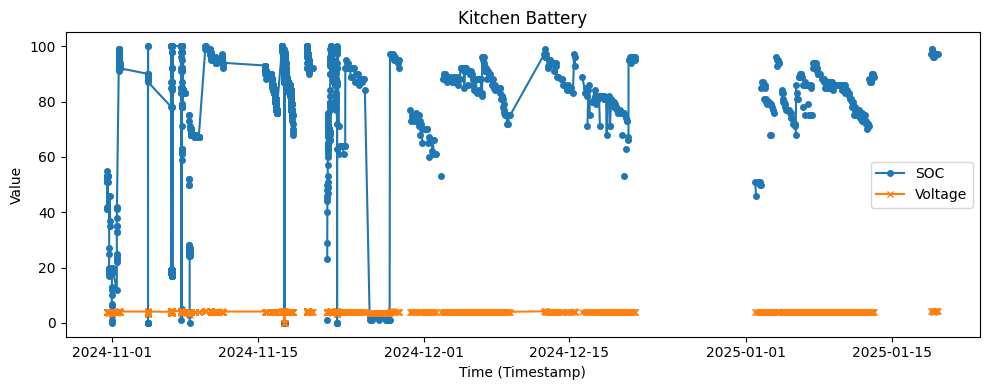

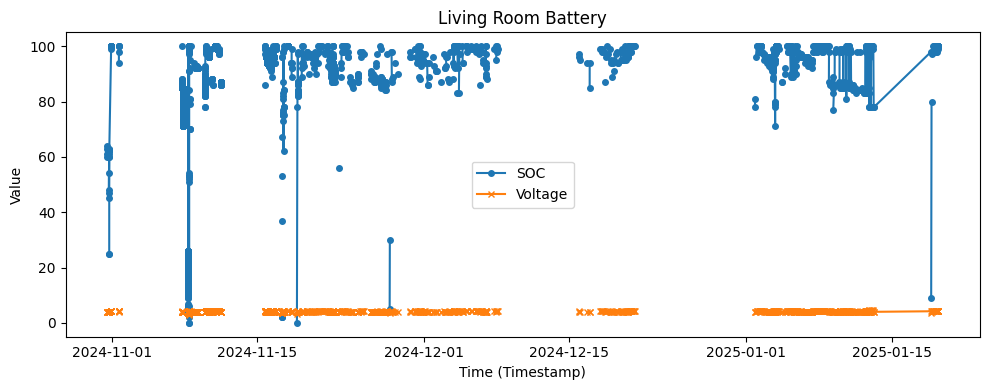

In [94]:
import matplotlib.pyplot as plt

# --- Kitchen Battery ---
fig_kitchen, ax_kitchen = plt.subplots(figsize=(10, 4))
ax_kitchen.plot(df_pivot.index,
                df_pivot[('kitchen_battery', 'soc')],
                label='SOC',
                marker='o',
                markersize=4)
ax_kitchen.plot(df_pivot.index,
                df_pivot[('kitchen_battery', 'voltage')],
                label='Voltage',
                marker='x',
                markersize=4)
ax_kitchen.set_title('Kitchen Battery')
ax_kitchen.legend()
ax_kitchen.set_ylabel('Value')
ax_kitchen.set_xlabel('Time (Timestamp)')
plt.tight_layout()
fig_kitchen.savefig('kitchen_battery.pdf')
plt.show()

# --- Living Room Battery ---
fig_livingroom, ax_livingroom = plt.subplots(figsize=(10, 4))
ax_livingroom.plot(df_pivot.index,
                   df_pivot[('livingroom_battery', 'soc')],
                   label='SOC',
                   marker='o',
                   markersize=4)
ax_livingroom.plot(df_pivot.index,
                   df_pivot[('livingroom_battery', 'voltage')],
                   label='Voltage',
                   marker='x',
                   markersize=4)
ax_livingroom.set_title('Living Room Battery')
ax_livingroom.legend()
ax_livingroom.set_ylabel('Value')
ax_livingroom.set_xlabel('Time (Timestamp)')
plt.tight_layout()
fig_livingroom.savefig('livingroom_battery.pdf')
plt.show()


## Emergency Detection

In [95]:
import pandas as pd
from patient_emergency_detection import emergency_detection_workflow, prepare_data_for_detection, detect_emergency
from base.minio_utils import load_model_from_minio
from base.influx_utils import fetch_all_sensor_data
from base.homecare_hub_utils import send_todo

In [96]:
sensor_data = fetch_all_sensor_data(
    start_hours=24 * 7 * 50,
    interval_hours=24 * 7 *50
)
prepared_df = prepare_data_for_detection(sensor_data)
prepared_df.tail(5)

2025-01-19 14:35:55 [INFO] patient_emergency_detection - Starting data preparation for detection.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Original data shape: (28144, 5)
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Handled 'sensor' as a list.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Timestamps converted to datetime.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Data sorted by timestamp.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Sensor names encoded successfully.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Mapped sensors to rooms.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Identified room-change points and assigned group IDs.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Calculated start and end times for each group.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Computed durations for each group.
2025-01-19 14:35:55 [INFO] patient_emergency_detection - Excluded 328 doo

,group_id,room,start_time,end_time,duration,duration_seconds
3550,3878,livingroom,2025-01-19 12:29:21.365,2025-01-19 12:29:21.365,0 days 00:00:00,0.000
3551,3879,bathroom,2025-01-19 12:29:21.574,2025-01-19 12:29:28.052,0 days 00:00:06.478000,6.478
3552,3880,livingroom,2025-01-19 12:29:44.425,2025-01-19 12:29:44.425,0 days 00:00:00,0.000
3553,3881,kitchen,2025-01-19 12:30:22.645,2025-01-19 12:47:21.863,0 days 00:16:59.218000,1019.218
3554,3883,kitchen,2025-01-19 12:47:57.632,2025-01-19 13:10:38.655,0 days 00:22:41.023000,1361.023


In [97]:
room_stats = load_model_from_minio("occupancy")
room_stats

2025-01-19 14:35:55 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:35:55 [INFO] base.minio_utils - [OCCUPANCY MODEL] Loading model 'model_occupancy_20250119112830.json' (version 1).
2025-01-19 14:35:55 [INFO] base.minio_utils - [OCCUPANCY MODEL] 'model_occupancy_20250119112830.json' downloaded.
2025-01-19 14:35:55 [INFO] base.minio_utils - [OCCUPANCY MODEL] Model deserialized successfully.


,room,mean,std
0,bathroom,1047.061526,26881.649307
1,kitchen,1257.734396,16011.675784
2,livingroom,1057.105833,4733.525599


In [98]:
_, message = emergency_detection_workflow()
print(message)

2025-01-19 14:35:55 [INFO] patient_emergency_detection - Initiating emergency detection workflow.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Fetched 574 sensor data records.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Retrieving patient location and duration.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Starting data preparation for detection.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Original data shape: (574, 5)
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Handled 'sensor' as a list.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Timestamps converted to datetime.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Data sorted by timestamp.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Sensor names encoded successfully.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Mapped sensors to rooms.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Identified room-change points and assi

✅ All is well! ✅
 Patient is currently in kitchen for 0:22:41.
 No emergency detected.
 Expected duration (mean): 0:20:58,
 Standard deviation (std): 4:26:52,
 Allowed duration range: 0:00:00 - 13:41:33.


In [99]:
room = "livingroom"
duration = 240  # seconds
stats = pd.Series({"mean": 120, "std": 30})

_, result = detect_emergency(room, duration, stats)
print(result)

2025-01-19 14:35:56 [INFO] patient_emergency_detection - Room 'livingroom' stats - Mean: 120.00 seconds, Std: 30.00 seconds.
2025-01-19 14:35:56 [INFO] patient_emergency_detection - Duration bounds for emergency detection: (30.00, 210.00) seconds.
2025-01-19 14:35:56 [WARNING] patient_emergency_detection - 🚨 Emergency Alert! 🚨
 Room: livingroom,
 Patient has spent 0:04:00 here.
 Expected duration (mean): 0:02:00,
 Standard deviation (std): 0:00:30,
 Threshold used: 3,
 Allowed duration range: 0:00:30 - 0:03:30,
Duration is outside the allowed range!


🚨 Emergency Alert! 🚨
 Room: livingroom,
 Patient has spent 0:04:00 here.
 Expected duration (mean): 0:02:00,
 Standard deviation (std): 0:00:30,
 Threshold used: 3,
 Allowed duration range: 0:00:30 - 0:03:30,
Duration is outside the allowed range!


In [100]:
send_todo("🚨 Patient Emergency! 🚨", result, 2)

ToDo item saved successfully.
Response: None


## Motion Analysis

In [134]:
from motion_analysis import (
    visualize_transitions_heatmap, 
    plot_bidirectional_transaction_graph, 
    summary_of_sleep_time_and_time_outside,
    count_daily_visits,
    detect_wake_up_times,
    detect_went_to_sleep_times,
    create_separate_heat_maps)
from base.minio_utils import load_model_from_minio
import pandas as pd
from base.homecare_hub_utils import send_info
from motion_analysis import analyse_motion_patterns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [135]:
old_model = load_model_from_minio("motion", 2)
new_model = load_model_from_minio("motion", 1)

2025-01-19 14:37:30 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:37:30 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250119133720.json' (version 2).
2025-01-19 14:37:30 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250119133720.json' downloaded.
2025-01-19 14:37:30 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-19 14:37:30 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:37:30 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250119133720.json' (version 1).
2025-01-19 14:37:30 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250119133720.json' downloaded.
2025-01-19 14:37:30 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.


In [136]:
old_model.head()

,from,to,leave_time,enter_time
0,kitchen,livingroomdoor,2024-12-01 20:31:42.731,2024-12-01 20:36:45.000
1,livingroomdoor,kitchen,2024-12-01 20:36:45.000,2024-12-01 20:39:15.834
2,kitchen,livingroomdoor,2024-12-01 21:58:06.390,2024-12-01 21:59:50.000
3,livingroomdoor,kitchen,2024-12-01 21:59:50.000,2024-12-01 22:10:11.228
4,kitchen,livingroomdoor,2024-12-01 22:10:40.673,2024-12-01 22:12:10.000


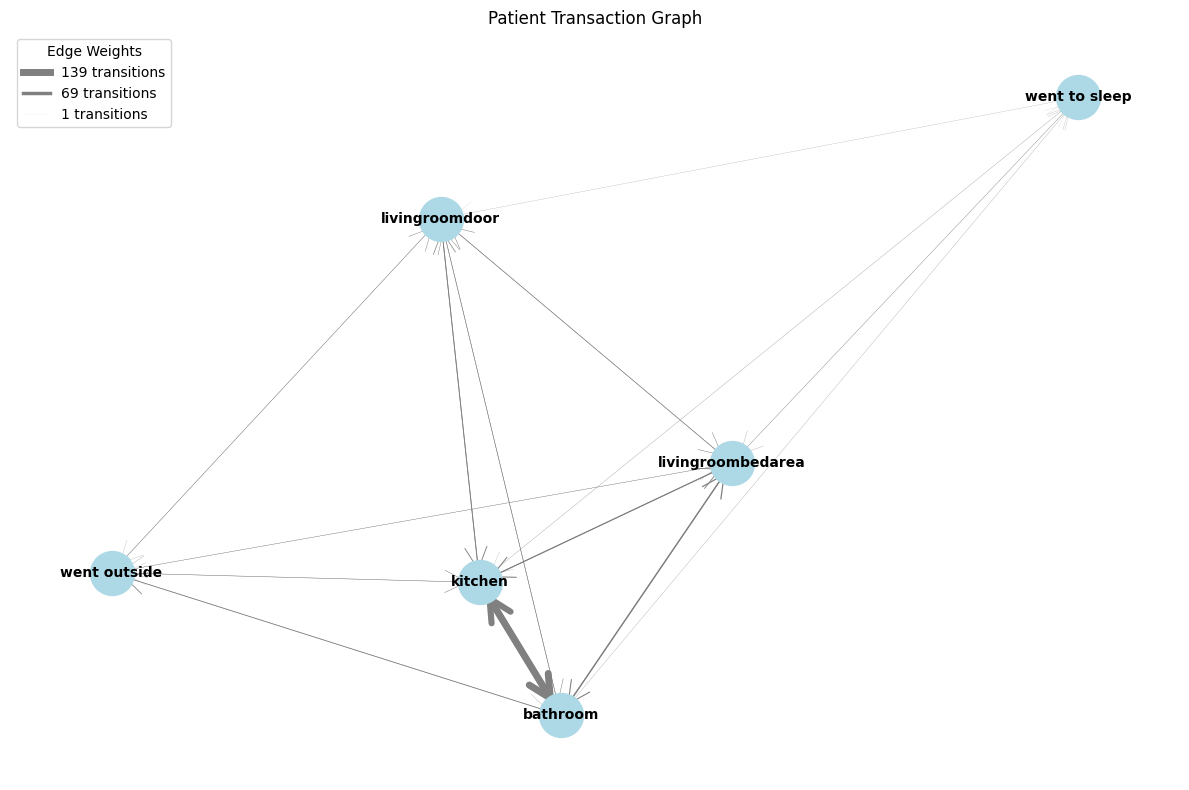

AttributeError: 'NoneType' object has no attribute 'savefig'

In [ ]:
plot_bidirectional_transaction_graph(old_model)


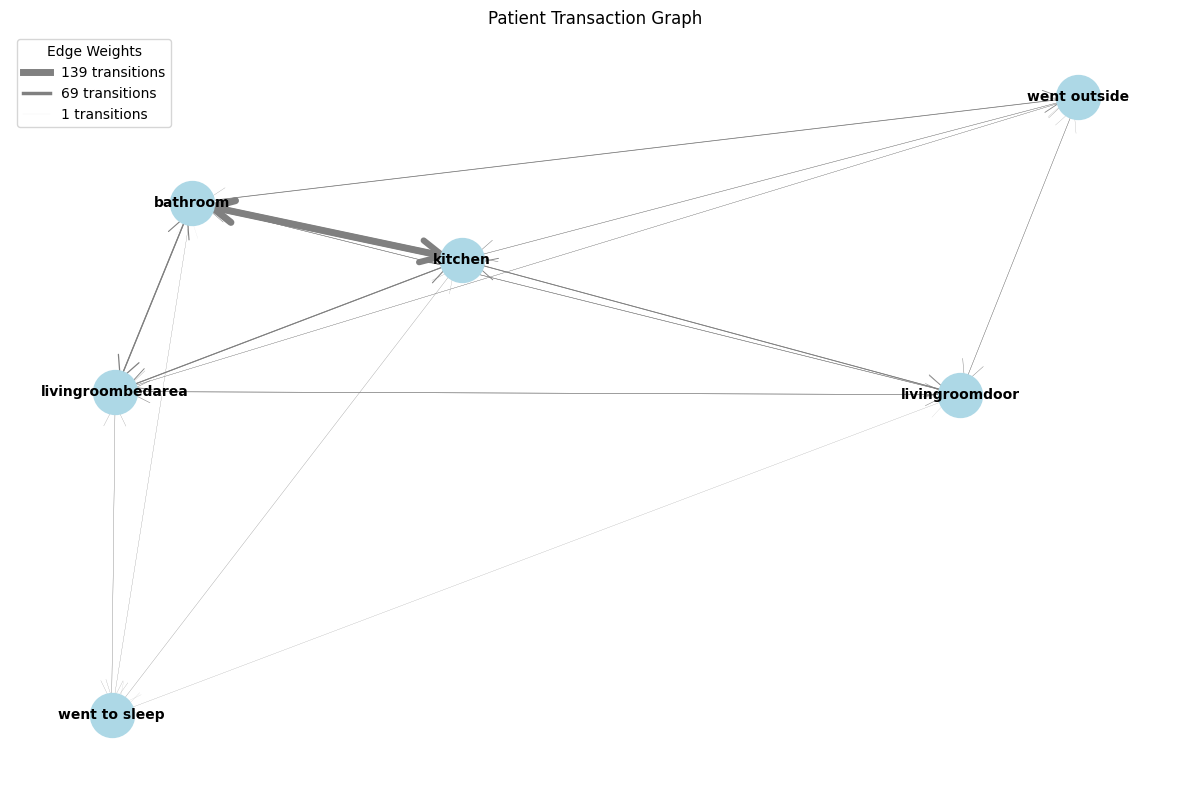

In [138]:
plot_bidirectional_transaction_graph(new_model)

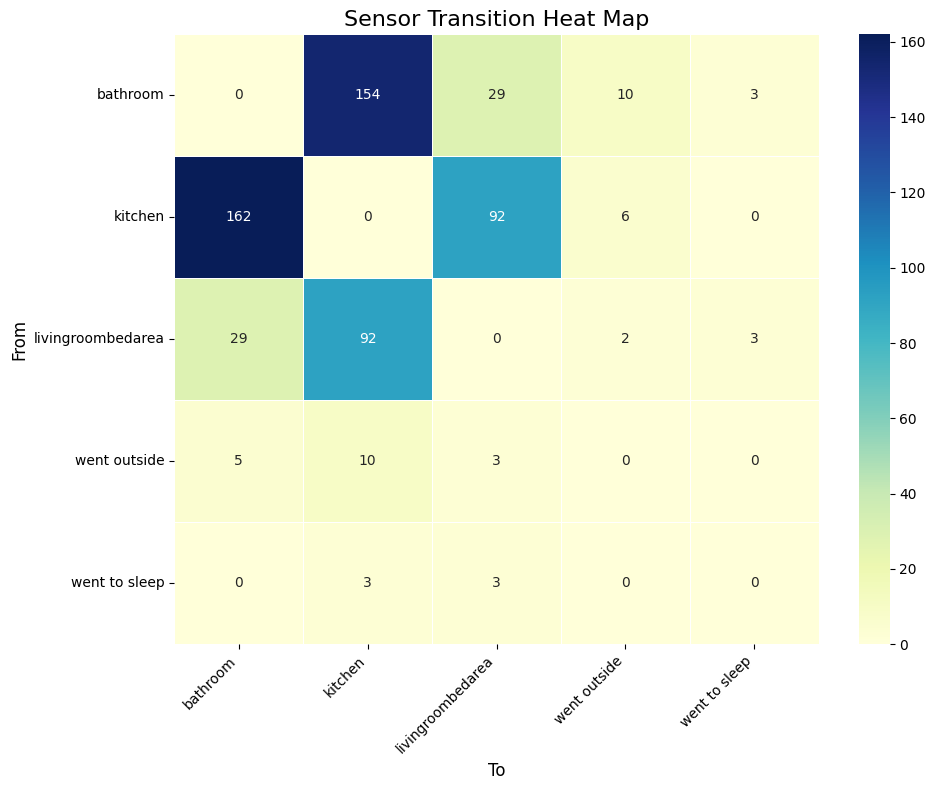

In [106]:
visualize_transitions_heatmap(old_model)

#### Counting the sleep and went outside periods

In [107]:
summary_of_sleep_time_and_time_outside(old_model)

,date,day_of_week,sleep_time,time_outside
0,2025-01-06,Monday,0h 14m,5h 12m
1,2025-01-07,Tuesday,2h 13m,5h 49m
2,2025-01-08,Wednesday,0h 33m,4h 40m
3,2025-01-09,Thursday,6h 8m,6h 29m
4,2025-01-10,Friday,1h 9m,5h 11m


In [108]:
summary_of_sleep_time_and_time_outside(new_model)

,date,day_of_week,sleep_time,time_outside
0,2025-01-13,Monday,1h 20m,13h 42m
1,2025-01-14,Tuesday,0,24h 0m
2,2025-01-15,Wednesday,0,24h 0m
3,2025-01-16,Thursday,0,24h 0m
4,2025-01-17,Friday,0,24h 0m
5,2025-01-18,Saturday,0,19h 32m


#### Detect daliy trips to places

In [109]:
count_daily_visits(new_model, transition_state='bathroom')

,trip_date,bathroom_trip_count
0,2025-01-12,58
1,2025-01-13,4
2,2025-01-18,5
3,2025-01-19,7


In [110]:
count_daily_visits(new_model, transition_state='kitchen')

,trip_date,kitchen_trip_count
0,2025-01-12,70
1,2025-01-13,6
2,2025-01-18,9
3,2025-01-19,15


In [111]:
count_daily_visits(new_model, transition_state='livingroombedarea')

,trip_date,livingroombedarea_trip_count
0,2025-01-12,21
1,2025-01-13,9
2,2025-01-18,5
3,2025-01-19,9


In [112]:
count_daily_visits(old_model, transition_state='livingroomdoor')

,trip_date,livingroomdoor_trip_count


#### Wake up times

In [113]:
detect_wake_up_times(new_model)

,wake_up_time
150,2025-01-13 06:23:38.764
156,2025-01-13 07:28:42.906


In [114]:
detect_went_to_sleep_times(old_model)

,went_to_sleep
84,2025-01-06 23:45:30.915
86,2025-01-07 06:45:53.291
155,2025-01-07 22:18:01.287
157,2025-01-08 01:22:28.128
217,2025-01-09 00:08:24.216
275,2025-01-10 05:01:55.899


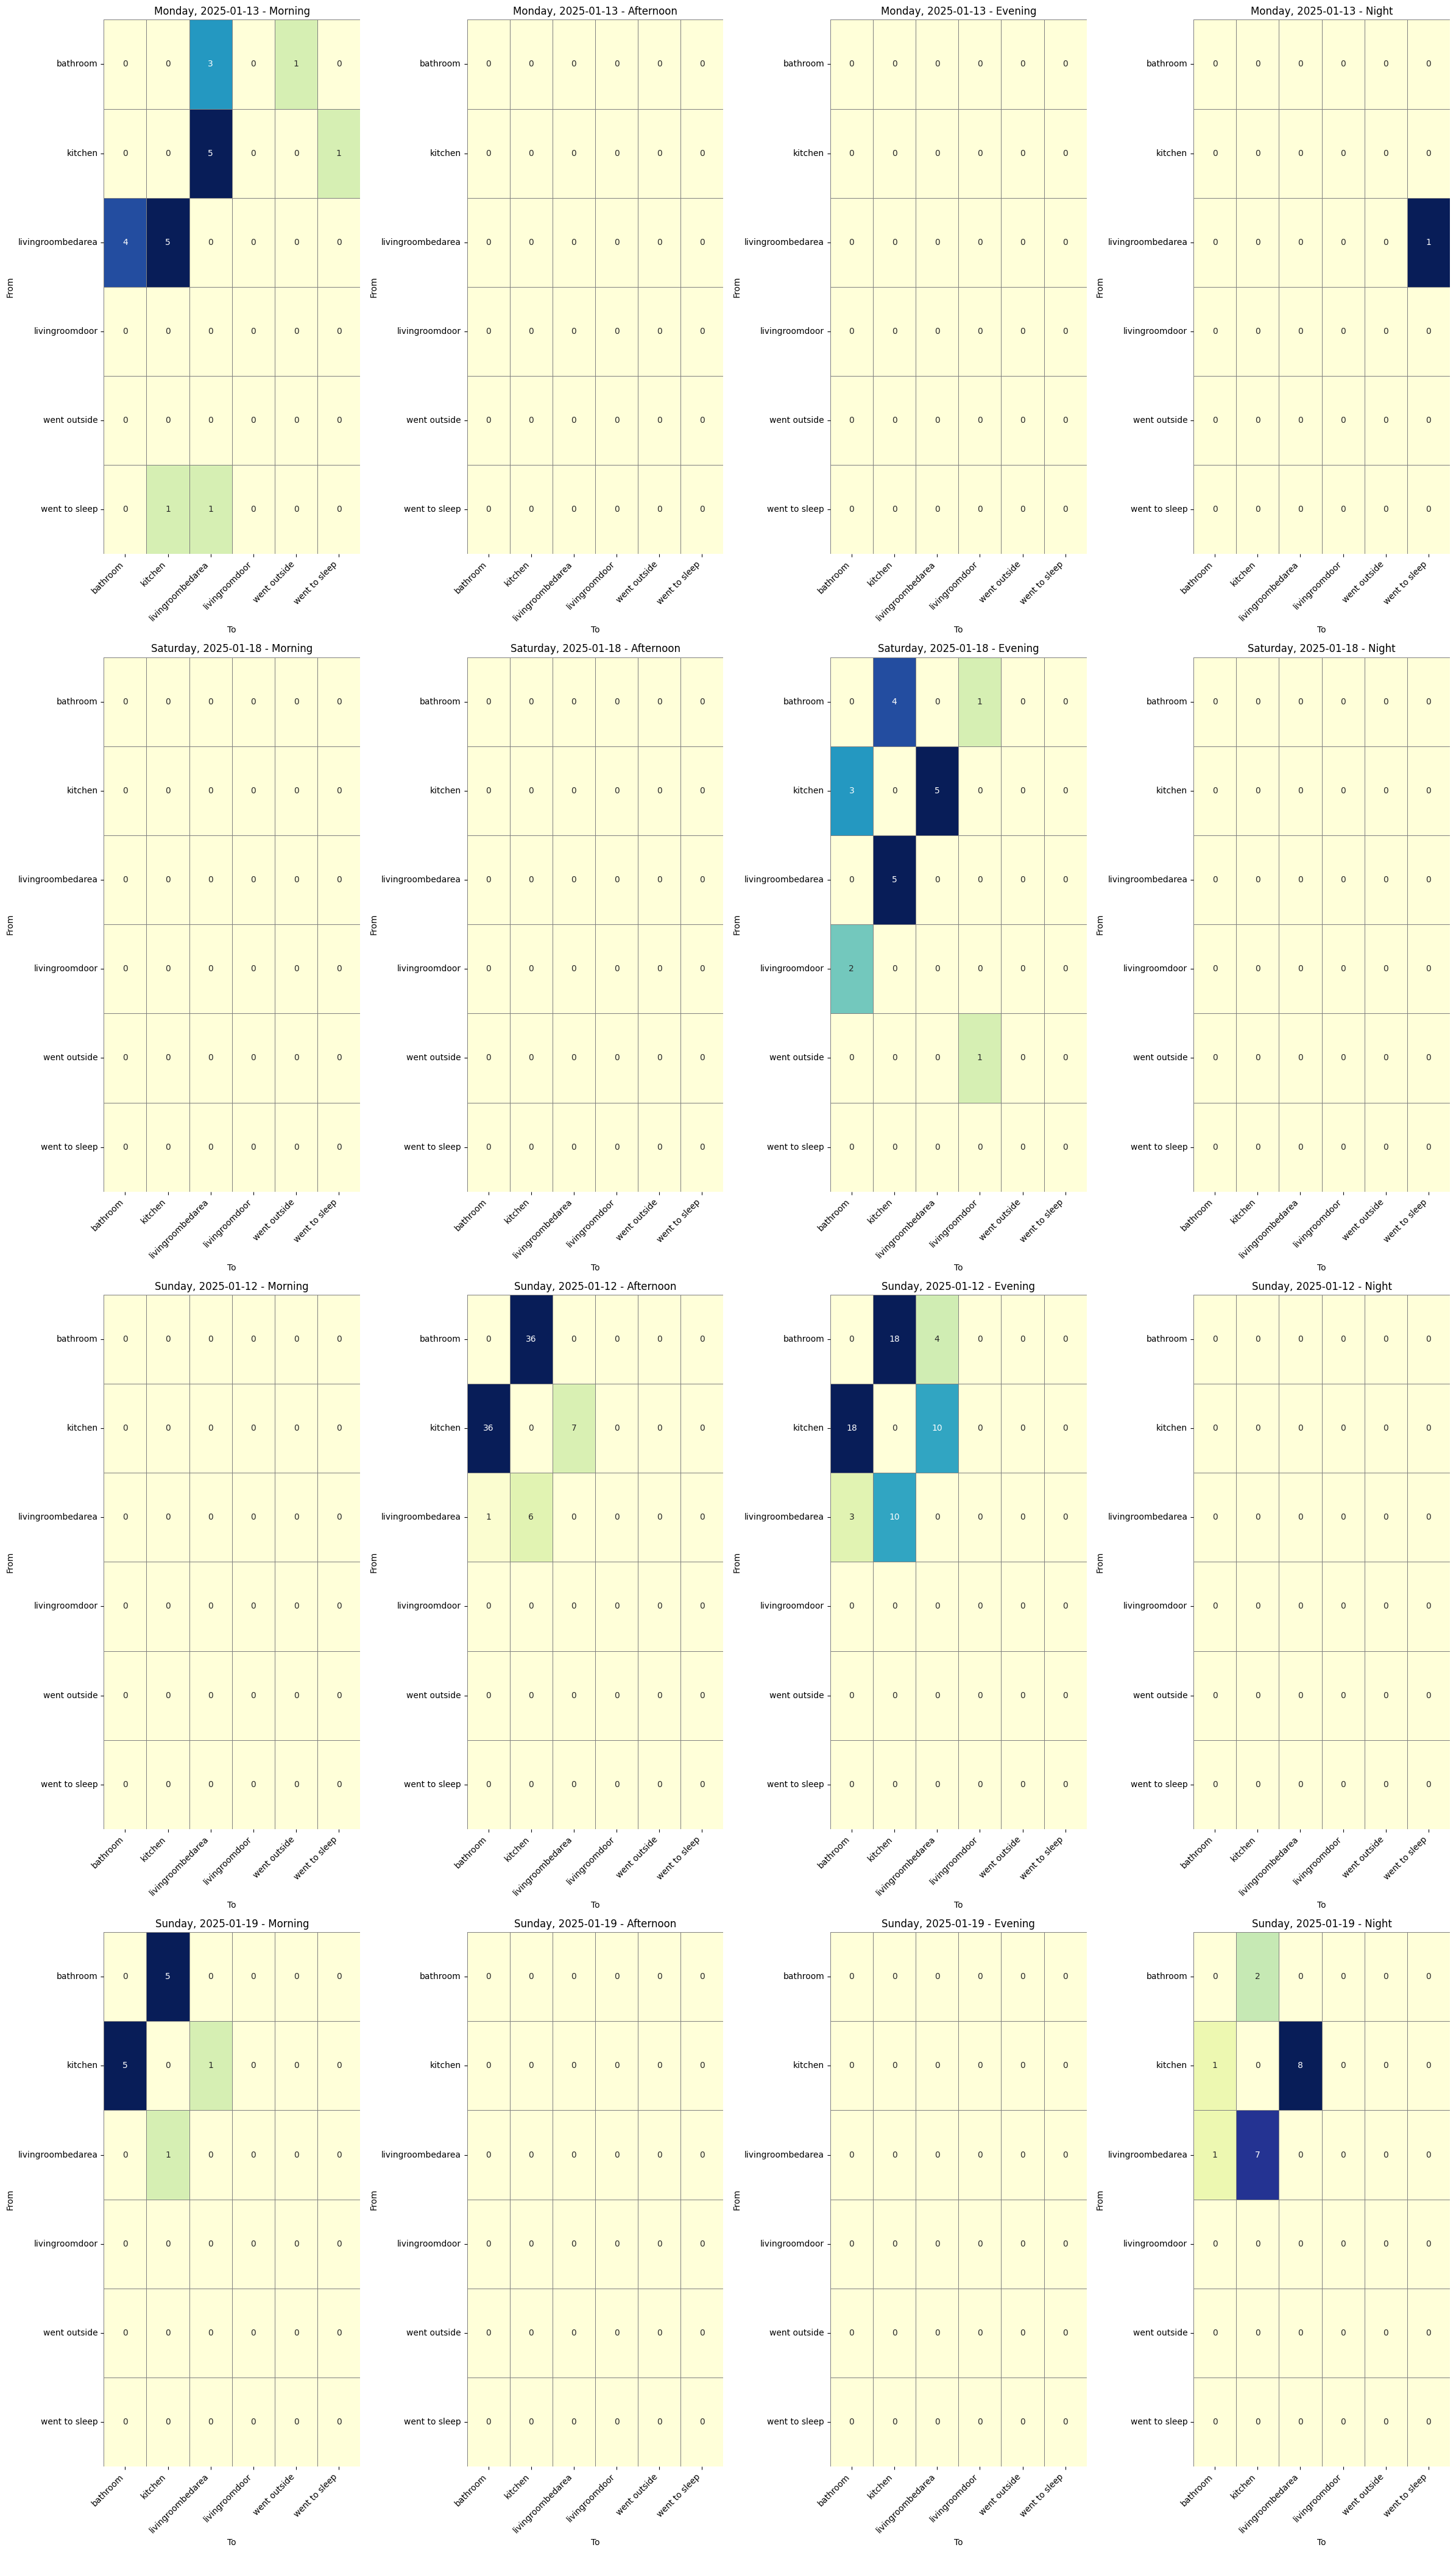

In [115]:
create_separate_heat_maps(new_model)

In [116]:
message = analyse_motion_patterns()

2025-01-19 14:36:05 [INFO] motion_analysis - 🔄 Loading old and new motion models from MinIO...
2025-01-19 14:36:05 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250113052158.json' (version 2).
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250113052158.json' downloaded.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-19 14:36:05 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250119072633.json' (version 1).
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250119072633.json' downloaded.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-19 14:36:05 [INFO] motion_analysis - ✅ Models loaded successfully.

2025-01-1

In [117]:
print(message)

📊 **📈 Motion Patterns Analysis Report 📉📊**

📅 **Report Date:** 2025-01-19 13:36:05 UTC

### 🕰️ **Old Motion Model** 🕰️

#### 🛌 Sleep Time and 🌳 Time Outside Summary

```      date day_of_week sleep_time time_outside
2025-01-06      Monday     0h 14m       5h 12m
2025-01-07     Tuesday     2h 13m       5h 49m
2025-01-08   Wednesday     0h 33m       4h 40m
2025-01-09    Thursday      6h 8m       6h 29m
2025-01-10      Friday      1h 9m       5h 11m```

#### 🚽 **Daily Visits to Bathroom**

``` trip_date  bathroom_trip_count
2025-01-06                   32
2025-01-07                   23
2025-01-08                   18
2025-01-09                    6
2025-01-10                   35
2025-01-11                   24
2025-01-12                   58```

#### 🚽 **Daily Visits to Kitchen**

``` trip_date  kitchen_trip_count
2025-01-06                  27
2025-01-07                  32
2025-01-08                  23
2025-01-09                  13
2025-01-10                  50
2025-01-11          

In [118]:
from motion_analysis import analyse_motion_patterns
analyse_motion_patterns()

2025-01-19 14:36:05 [INFO] motion_analysis - 🔄 Loading old and new motion models from MinIO...
2025-01-19 14:36:05 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250113052158.json' (version 2).
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250113052158.json' downloaded.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-19 14:36:05 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250119072633.json' (version 1).
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250119072633.json' downloaded.
2025-01-19 14:36:05 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-19 14:36:05 [INFO] motion_analysis - ✅ Models loaded successfully.

2025-01-1

'📊 **📈 Motion Patterns Analysis Report 📉📊**\n\n📅 **Report Date:** 2025-01-19 13:36:05 UTC\n\n### 🕰️ **Old Motion Model** 🕰️\n\n#### 🛌 Sleep Time and 🌳 Time Outside Summary\n\n```      date day_of_week sleep_time time_outside\n2025-01-06      Monday     0h 14m       5h 12m\n2025-01-07     Tuesday     2h 13m       5h 49m\n2025-01-08   Wednesday     0h 33m       4h 40m\n2025-01-09    Thursday      6h 8m       6h 29m\n2025-01-10      Friday      1h 9m       5h 11m```\n\n#### 🚽 **Daily Visits to Bathroom**\n\n``` trip_date  bathroom_trip_count\n2025-01-06                   32\n2025-01-07                   23\n2025-01-08                   18\n2025-01-09                    6\n2025-01-10                   35\n2025-01-11                   24\n2025-01-12                   58```\n\n#### 🚽 **Daily Visits to Kitchen**\n\n``` trip_date  kitchen_trip_count\n2025-01-06                  27\n2025-01-07                  32\n2025-01-08                  23\n2025-01-09                  13\n2025-01-10       

## Burglary Detection

In [119]:
from burglary_detection import BurglaryDetector
from burglary_detection import create_burglary_message, detect_burglary
from motion_model import train_motion_model
from base.homecare_hub_utils import send_todo

In [120]:
detector = BurglaryDetector(contamination=0.01, model_type='burglary')
detector.load_model(version=1)

2025-01-19 14:36:06 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:36:06 [INFO] base.minio_utils - [BURGLARY MODEL] Loading model 'model_burglary_20250119072631.json' (version 1).
2025-01-19 14:36:07 [INFO] base.minio_utils - [BURGLARY MODEL] 'model_burglary_20250119072631.json' downloaded.
2025-01-19 14:36:07 [INFO] base.minio_utils - [BURGLARY MODEL] Model deserialized successfully.


Model version 1 loaded from MinIO successfully.


In [121]:
motion_model = train_motion_model(start_hours=24*7, interval_hours=24*7, time_threshold_seconds=1800)
detection = detector.detect(motion_model)

2025-01-19 14:36:07 [INFO] motion_model - Fetching sensor data starting 168 hours ago for a duration of 168 hours.
2025-01-19 14:36:07 [INFO] motion_model - Preparing data for occupancy model.
2025-01-19 14:36:07 [INFO] occupancy_model - Original data shape: (1522, 5)
2025-01-19 14:36:07 [INFO] motion_model - Preprocessing data for motion analysis.
2025-01-19 14:36:08 [INFO] motion_model - Creating transition DataFrame with a time threshold of 1800 seconds.
2025-01-19 14:36:08 [INFO] motion_model - Motion model trained.
2025-01-19 14:36:08 [INFO] burglary_detection - Anomaly detected: Yes


In [122]:
detection

(                  from                 to              leave_time  \
 0              kitchen           bathroom 2025-01-12 13:38:53.729   
 1             bathroom            kitchen 2025-01-12 13:42:05.107   
 2              kitchen           bathroom 2025-01-12 13:42:08.097   
 3             bathroom            kitchen 2025-01-12 13:44:44.486   
 4              kitchen           bathroom 2025-01-12 13:54:15.813   
 5             bathroom            kitchen 2025-01-12 13:57:30.334   
 6              kitchen           bathroom 2025-01-12 14:00:02.042   
 7             bathroom            kitchen 2025-01-12 14:00:11.905   
 8              kitchen           bathroom 2025-01-12 14:00:19.357   
 9             bathroom            kitchen 2025-01-12 14:00:28.632   
 10             kitchen           bathroom 2025-01-12 14:00:31.055   
 11            bathroom            kitchen 2025-01-12 14:01:07.602   
 12             kitchen           bathroom 2025-01-12 14:01:17.930   
 13            bathr

In [123]:
create_burglary_message(detection[0], detection[1])

2025-01-19 14:36:08 [INFO] burglary_detection - Burglary alert message created successfully.


'🚔 **Burglary Alert!** 🚔\nPotential burglary detected with the following details:\n\n🔹 **From:** livingroombedarea ➡️ **To:** bathroom\n🔸 **Leave Time:** 2025-01-19 00:56:47\n🔸 **Enter Time:** 2025-01-19 01:10:05\n\n⚠️ Please check the premises immediately. ⚠️'

In [124]:
is_burglary, msg = detect_burglary(24*7, 24*7, 1800)
if is_burglary:
    send_todo("🏠🚔 Burglary Alert! 🏠🔐", msg, 2)

2025-01-19 14:36:08 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:36:08 [INFO] base.minio_utils - [BURGLARY MODEL] Loading model 'model_burglary_20250119072631.json' (version 1).
2025-01-19 14:36:08 [INFO] base.minio_utils - [BURGLARY MODEL] 'model_burglary_20250119072631.json' downloaded.
2025-01-19 14:36:08 [INFO] base.minio_utils - [BURGLARY MODEL] Model deserialized successfully.
2025-01-19 14:36:08 [INFO] motion_model - Fetching sensor data starting 168 hours ago for a duration of 168 hours.


Model version 1 loaded from MinIO successfully.


2025-01-19 14:36:09 [INFO] motion_model - Preparing data for occupancy model.
2025-01-19 14:36:09 [INFO] occupancy_model - Original data shape: (1522, 5)
2025-01-19 14:36:09 [INFO] motion_model - Preprocessing data for motion analysis.
2025-01-19 14:36:09 [INFO] motion_model - Creating transition DataFrame with a time threshold of 1800 seconds.
2025-01-19 14:36:09 [INFO] motion_model - Motion model trained.
2025-01-19 14:36:09 [INFO] burglary_detection - Anomaly detected: Yes
2025-01-19 14:36:09 [INFO] burglary_detection - Burglary alert message created successfully.


ToDo item saved successfully.
Response: None


## Emergency detection over weeks for report

In [125]:
from base.minio_utils import load_model_from_minio

In [126]:
model = load_model_from_minio("occupancy")

2025-01-19 14:36:09 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-19 14:36:09 [INFO] base.minio_utils - [OCCUPANCY MODEL] Loading model 'model_occupancy_20250119112830.json' (version 1).
2025-01-19 14:36:09 [INFO] base.minio_utils - [OCCUPANCY MODEL] 'model_occupancy_20250119112830.json' downloaded.
2025-01-19 14:36:09 [INFO] base.minio_utils - [OCCUPANCY MODEL] Model deserialized successfully.


In [127]:
model

,room,mean,std
0,bathroom,1047.061526,26881.649307
1,kitchen,1257.734396,16011.675784
2,livingroom,1057.105833,4733.525599


In [128]:
prepared_df = prepare_data_for_detection(sensor_data)

2025-01-19 14:36:09 [INFO] patient_emergency_detection - Starting data preparation for detection.


2025-01-19 14:36:09 [INFO] patient_emergency_detection - Original data shape: (28144, 5)
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Handled 'sensor' as a list.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Timestamps converted to datetime.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Data sorted by timestamp.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Sensor names encoded successfully.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Mapped sensors to rooms.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Identified room-change points and assigned group IDs.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Calculated start and end times for each group.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Computed durations for each group.
2025-01-19 14:36:09 [INFO] patient_emergency_detection - Excluded 328 door-opening event(s) from the final DataFrame.
2025-01-19 14:36:09 [INFO] patient_emergency_detectio

In [129]:
duration_df = prepared_df

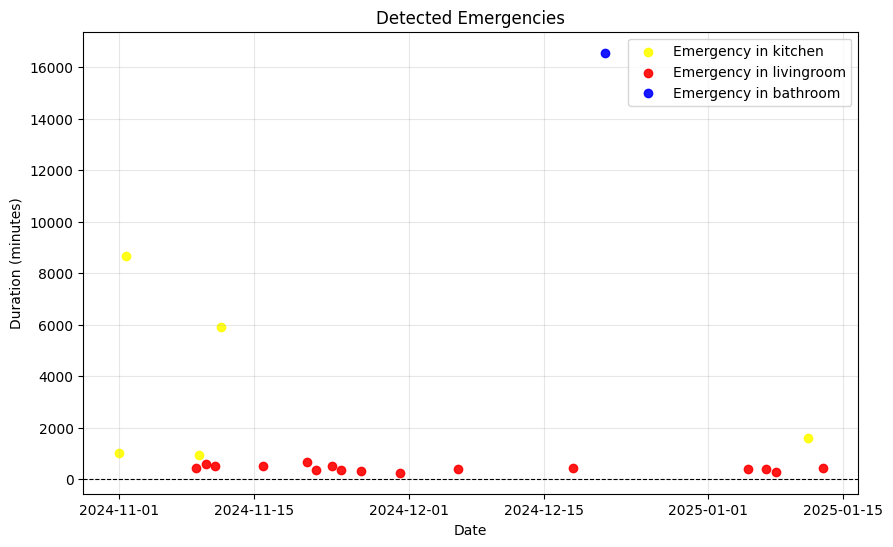

In [130]:
# Convert duration_seconds to minutes
duration_df['duration_minutes'] = duration_df['duration_seconds'] / 60

# Detect emergencies based on 3 standard deviations from the mean
def detect_emergencies(row, stats_df):
    stats = stats_df[stats_df['room'] == row['room']]
    if stats.empty:
        return False
    mean = stats['mean'].values[0]
    std = stats['std'].values[0]
    lower_bound = max(mean - 3 * std, 0)
    upper_bound = mean + 3 * std
    return row['duration_seconds'] < lower_bound or row['duration_seconds'] > upper_bound

duration_df['emergency'] = duration_df.apply(detect_emergencies, axis=1, stats_df=stats_df)

# Filter emergencies
emergencies_df = duration_df[duration_df['emergency']]

# Define colors for each room
room_colors = {
    'kitchen': 'yellow',
    'livingroom': 'red',
    'bathroom': 'blue'
}

plt.figure(figsize=(10, 6))

if not emergencies_df.empty:
    for room, color in room_colors.items():
        room_emergencies = emergencies_df[emergencies_df['room'] == room]
        plt.scatter(room_emergencies['start_time'], room_emergencies['duration_minutes'], color=color, label=f"Emergency in {room}", alpha=0.9)

plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Duration (minutes)')
plt.title('Detected Emergencies')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('detected_emergencies.pdf')
plt.show()


In [131]:
emergencies_df

,group_id,room,start_time,end_time,duration,duration_seconds,duration_minutes,emergency
13,16,kitchen,2024-10-31 22:46:58.000,2024-11-01 15:33:11.000,0 days 16:46:13,60373.000,1006.216667,True
79,82,kitchen,2024-11-01 17:32:35.000,2024-11-07 17:54:14.000,6 days 00:21:39,519699.000,8661.650000,True
176,250,livingroom,2024-11-08 23:39:57.000,2024-11-09 07:10:22.000,0 days 07:30:25,27025.000,450.416667,True
182,257,kitchen,2024-11-09 07:36:46.000,2024-11-09 23:15:31.000,0 days 15:38:45,56325.000,938.750000,True
186,262,livingroom,2024-11-09 23:34:29.000,2024-11-10 09:24:30.000,0 days 09:50:01,35401.000,590.016667,True
215,295,livingroom,2024-11-10 22:50:00.000,2024-11-11 07:19:16.000,0 days 08:29:16,30556.000,509.266667,True
245,328,kitchen,2024-11-11 14:48:10.000,2024-11-15 17:17:16.000,4 days 02:29:06,354546.000,5909.100000,True
308,398,livingroom,2024-11-15 21:58:27.000,2024-11-16 06:53:12.000,0 days 08:54:45,32085.000,534.750000,True
540,675,livingroom,2024-11-20 10:17:09.563,2024-11-20 21:41:17.408,0 days 11:24:07.845000,41047.845,684.130750,True
544,679,livingroom,2024-11-21 09:03:39.394,2024-11-21 15:18:02.984,0 days 06:14:23.590000,22463.590,374.393167,True
